# Import

In [1]:
# installations
# !pip install mne
# !pip install tensorflow
# !pip install seaborn
# !pip install sklearn

In [2]:
import scipy.io
from scipy.fftpack import fft

import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme()

from mne.filter import filter_data, notch_filter
import mne

In [3]:
# for training the model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Constants

In [4]:
recording_freq = 250  # how frequent our data streamer is getting the data, in this case, 250 Hz, in other words, we'll get 1 timepoint every 4 ms = 1000 / 250
timepoint_to_ms = 1 / recording_freq * 1000
epoch_length = 2840  # maybe ms
ms_to_timepoint = 1 / timepoint_to_ms
num_blocks = 10
channels = ['POz', 'PO3', 'PO4', 'PO5', 'PO6', 'Oz', 'O1', 'O2']
meta = {
  'recording_freq':recording_freq, # unit: Hz
  'timepoint_to_ms':timepoint_to_ms, # equals 4 ms/timepoint
  'ms_to_timepoint':ms_to_timepoint, # equals 0.25 timepoint/ms
  'num_channels':len(channels),
  'epoch_length': epoch_length, # unit: ms
  'epoch_length_timepoint':int(epoch_length * ms_to_timepoint), # equals 710 timepoint
  'channels':channels, # the exact same order as X
  'epoch_start': -500, # unit: ms
  'onset': 0, # unit: ms
  'electrode_index': dict(dry=1, wet=2),
  'blocks': list(range(num_blocks)),
  'num_blocks': num_blocks,
  'num_classes': 12,
  'num_subjects': 10,
  'stimulation_freq': [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25,
                       12.25, 14.25, 10.75, 12.75, 14.75]
}

In [5]:
montage = mne.channels.make_standard_montage('standard_1020')
info = mne.create_info(ch_names=meta['channels'], sfreq=meta['recording_freq'], ch_types=['eeg'] * meta['num_channels'])

# Helper Functions

In [6]:
def get_epoch_data(patient_dict, electrode_type='wet'):
    '''
    Get epoched data from the patient json file
    Args:
        patient_dict: dictionary of the patient data
        electrode_type: "dry" or "wet" 
    Return:
        X: (blocks, num_classes, num_channels, timepoint)
        y: (blocks, num_classes)
    '''

    if electrode_type == 'dry':
        index = 0
    elif electrode_type == 'wet':
        index = 1
  
    X = patient_dict['data']
    X = X[:, :, index, :, :]
    X = X.transpose([2, 3, 0, 1])

    y = np.tile(np.arange(0, 12), [meta['num_blocks'], 1])

    return X, y

# Description of the dataset Wearable SSVEP BCI Dataset
* 10 blocks, 12 trials (i.e. targets) per block
* 8 channels
* y (0: class_1, 1: class_2, ... 11: class_12)
* 250 Hz, 4 ms/timepoint
* each trial is 2.84 s (0.5s before stimulus onset, 2s for stimulation, 0.14s visual latency, and 0.2s after stimulus offset), and is corresponding with each target [0, 1, 2, ... 11]

## Load all patient data

In [7]:
data_path = "../data/arico_dataset"
patient_data = [scipy.io.loadmat(os.path.join(data_path, file)) for file in os.listdir(data_path) if ".mat" in file]

## Preprocessing

In [8]:
def preprocess_data(X_orig, l_freq, h_freq, notch_freq=None, method='fir', ref_type=None):
    '''
    Perform standard processing pipeline on the input data
    Args:
    X_orig: (blocks, num_classes, num_channels, timepoint)
    Return:
    X: (blocks, num_classes, num_channels, timepoint)
    ref_type: 'average', 'REST'
    '''
    X = np.zeros(X_orig.shape)
    for i in range(len(X)):
        X_slice = X_orig[i]

        # re-referencing
        if ref_type is not None:
            X_slice = mne.EpochsArray(X_orig[i].copy(), info=info, verbose=0, baseline=(None, None))
            X_slice.set_montage(montage)
            X_slice, _ = mne.set_eeg_reference(X_slice, ref_channels=ref_type, verbose=0)
        # notch-filtering
        if notch_freq is not None:
            X_slice = notch_filter(X_slice, Fs=meta['recording_freq'], freqs=notch_freq, verbose=0, method=method)
        # bandpassing
        X_slice = filter_data(X_slice, sfreq=meta['recording_freq'], l_freq=l_freq, h_freq=h_freq, verbose=0, method=method)

        X[i] = X_slice
    return X

In [9]:
# preprocess all subjects
X_all_subjects = np.zeros([len(patient_data), meta['num_blocks'], meta['num_classes'], meta['num_channels'], meta['epoch_length_timepoint']])
y_all_subjects = np.zeros([len(patient_data), meta['num_blocks'], meta['num_classes']])
l_freq = 7.25
h_freq = 90
notch_freq = 50
method = 'iir'
ref_type = 'average'

for i in range(len(X_all_subjects)):
    X_orig, y_orig = get_epoch_data(patient_data[i], electrode_type='wet')
    X = preprocess_data(X_orig, l_freq=l_freq, h_freq=h_freq, notch_freq=notch_freq, method=method, ref_type=ref_type)
    X_all_subjects[i] = X
    y_all_subjects[i] = y_orig

## Take a look at all subjects

SSVEPs at several frequencies from the Oz channel were averaged across all blocks for all subjects

In [10]:
freq_picks = [9.25, 9.75, 13.25]
freq_picks_string = ", ".join([str(x) for x in freq_picks])
channel = 'Oz'
X = X_all_subjects.mean(axis=0)
X = X.mean(0)

In [11]:
# Time-domain analysis
target_avg_potentials = np.zeros([len(freq_picks), meta['epoch_length_timepoint']])
for i, freq_pick in enumerate(freq_picks):
    target_avg_potential = X[meta['stimulation_freq'].index(freq_pick), meta['channels'].index(channel), :]
    target_avg_potentials[i, :] = target_avg_potential

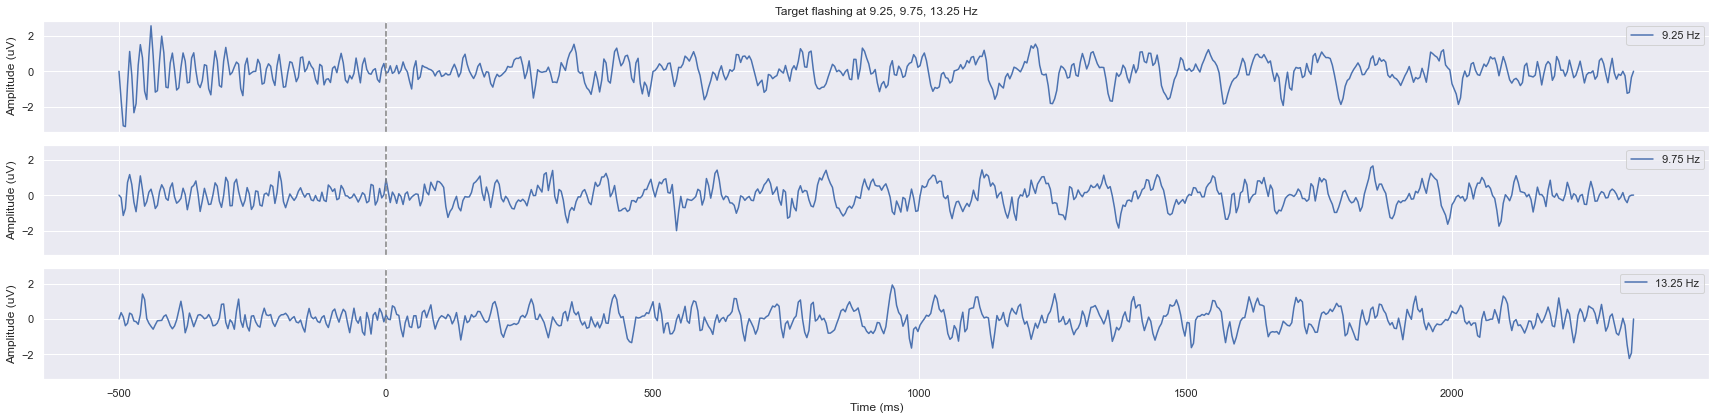

In [12]:
f, axes = plt.subplots(figsize=(24, 6), nrows=len(freq_picks), ncols=1, sharex=True, sharey=True)
if len(freq_picks) == 1:
    axes = [axes]

xticks = np.linspace(meta['epoch_start'], meta['epoch_start'] + meta['epoch_length'], meta['epoch_length_timepoint'])
for i, ax in enumerate(axes):
    sns.lineplot(x=xticks, y=target_avg_potentials[i], ax=ax, label=f'{freq_picks[i]} Hz');
    ax.set(ylabel='Amplitude (uV)')
    ax.axvline(x=meta['onset'], linestyle='--', color='gray')
    ax.legend(loc='upper right')
axes[0].set_title(f'Target flashing at {freq_picks_string} Hz')
axes[-1].set_xlabel('Time (ms)');
plt.tight_layout()

In [13]:
# FFT, Frequency-domain analysis
freqs = np.linspace(0.0, meta['recording_freq'] / 2, int(meta['epoch_length_timepoint'] / 2))
freq_avg_potential = fft(X)[:, :, 0: int(meta['epoch_length_timepoint'] / 2)]
freq_avg_potential = 2 / meta['epoch_length_timepoint'] * np.abs(freq_avg_potential)

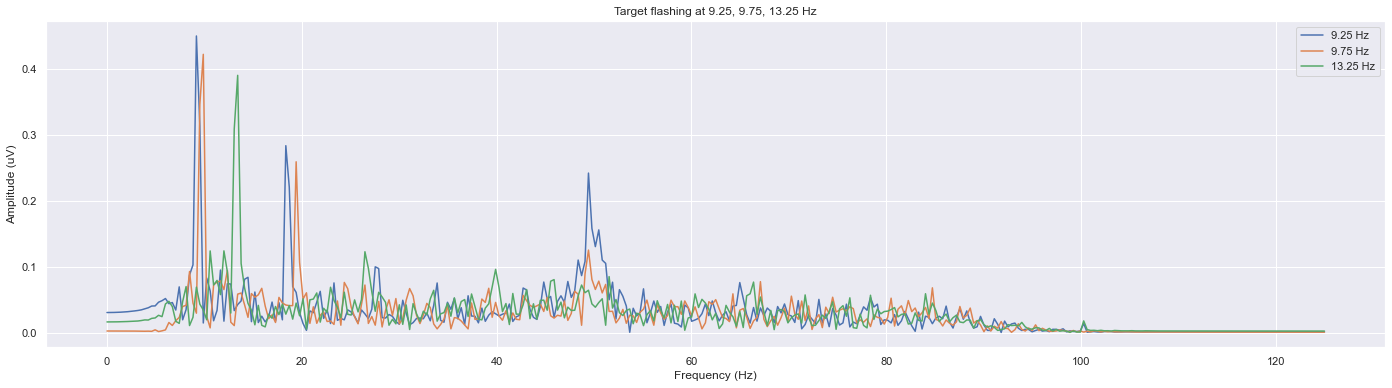

In [14]:
plt.figure(figsize=(24, 6))
ax = plt.subplot()
xticks = freqs
for freq_pick in freq_picks:
    yticks = freq_avg_potential[meta['stimulation_freq'].index(freq_pick), meta['channels'].index(channel), :]
    sns.lineplot(x=xticks, y=yticks, ax=ax, label=f"{freq_pick} Hz")

ax.set_title(f'Target flashing at {freq_picks_string} Hz')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude (uV)');

## Modeling

### EEGNet

In [15]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    model = Sequential()
    ##################################################################
    model.add(Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False))
    model.add(BatchNormalization())
    model.add(DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(AveragePooling2D((1, 4)))
    model.add(dropoutType(dropoutRate))
    
    model.add(SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(AveragePooling2D((1, 8)))
    model.add(dropoutType(dropoutRate))
        
    model.add(Flatten(name = 'flatten'))
    
    model.add(Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate)))
    model.add(Activation('softmax', name = 'softmax'))
    
    return model

#### Preprocessing
X has to be the shape (epochs, channels, timepoints, 1) <br>
y has to be the shape (epochs, class_num)

Let's do classification on one subject

In [16]:
subject_idx = 6
X_orig = X_all_subjects[subject_idx]
y_orig = y_all_subjects[subject_idx]
# reshape to required dimension
X_orig = X_orig[:, :, :, :, None]
X_orig.shape, y_orig.shape

((10, 12, 8, 710, 1), (10, 12))

#### Training

In [17]:
def get_eegnet_acc(X_orig, y_orig, channels=meta['channels'], blocks=meta['blocks'], time=list(range(0, meta['epoch_length_timepoint'])), epochs=250, return_model=False, batch_size=16, dropoutRate=0.45, lr=0.001, verbose=1):
    '''
    Arguments:
        X_orig: (num_blocks, num_classes, num_channels, timepoints, 1)
        y_orig: (num_blocks, num_classes)
        blocks: (num_blocks,)
        channels: (num_channels,)
        time: (timepoints, )
        return model: whether to return model
    Return:
        train_acc: avg of the kfolds (num_epochs)
        test_acc: avg of the kfolds (num_epochs)
    '''
    train_acc = np.zeros([len(blocks), epochs])
    test_acc = np.zeros(train_acc.shape)
    kf = KFold(n_splits=len(blocks))

    channel_idx = [meta['channels'].index(x) for x in channels]
    X_orig = X_orig[blocks]
    X_orig = X_orig[:, :, channel_idx]
    X_orig = X_orig[:, :, :, time]
    y_orig = y_orig[blocks]

    for i, (train_index, test_index) in enumerate(kf.split(X_orig)):
        if verbose >= 1:
            print(f"{i + 1} / {meta['num_blocks']} folds")
        X_train, X_test = X_orig[train_index], X_orig[test_index]
        y_train, y_test = y_orig[train_index], y_orig[test_index]

        X_train = X_train.reshape([-1, X_train.shape[2], X_train.shape[3], X_train.shape[4]])
        X_test = X_test.reshape([-1, X_test.shape[2], X_test.shape[3], X_test.shape[4]])
        y_train = y_train.reshape([-1])
        y_test = y_test.reshape([-1])

        model = EEGNet(nb_classes = meta['num_classes'], Chans = len(channels), 
                    Samples = len(time), 
                    dropoutRate = dropoutRate)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), 
                    metrics = ['acc'])

        if verbose < 2:
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_test, y_test))
        else:
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_test, y_test))

        if return_model:
            return model

        train_acc[i, :] = history.history['acc'] 
        test_acc[i, :] = history.history['val_acc']
    return train_acc.mean(axis=0), test_acc.mean(axis=0)

Let's first get a sense of the number of epochs needed to train EEGNet 

In [18]:
epochs = 4
batch_size = 64

In [19]:
# configure the EEGNet-8,2,16 model with kernel length of 64 samples (other 
# model configurations may do better, but this is a good starting point)
train_acc, test_acc = get_eegnet_acc(X_orig, y_orig, epochs=epochs, batch_size=batch_size, verbose=1)

1 / 10 folds


2022-02-20 14:50:08.131152: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2


2 / 10 folds
3 / 10 folds
4 / 10 folds
5 / 10 folds
6 / 10 folds
7 / 10 folds
8 / 10 folds
9 / 10 folds
10 / 10 folds


Text(0.5, 1.0, 'EEGNet')

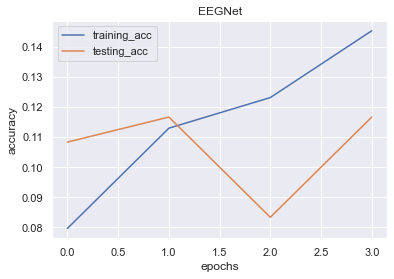

In [20]:
xticks = list(range(epochs))
# plot the avg across folds
ax = sns.lineplot(x=xticks, y=train_acc, label='training_acc')
ax = sns.lineplot(x=xticks, y=test_acc, label='testing_acc', ax=ax)
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.set_title('EEGNet')

## Analysis

In [21]:
subject_idx = 6
X_orig = X_all_subjects[subject_idx]
y_orig = y_all_subjects[subject_idx]
# reshape to required dimension
X_orig = X_orig[:, :, :, :, None]

epochs = 4
batch_size = 16
lr = 0.001
X_orig.shape, y_orig.shape

((10, 12, 8, 710, 1), (10, 12))

### Accuracy based on number of channels

In [22]:
channels = meta['channels']
val_acc = np.zeros([epochs, len(channels)])
train_acc = np.zeros(val_acc.shape)

We first look at the effect of each individual channel and then rank them. It might take a while to run

In [23]:
for i, chan in enumerate(channels):
    print(f"Channel {i + 1}/{len(channels)}")
    train_acc_slice, val_acc_slice = get_eegnet_acc(X_orig, y_orig, channels=[chan], epochs=epochs, verbose=0)
    val_acc[:, i] = val_acc_slice
    train_acc[:, i] = train_acc_slice

Channel 1/8
Channel 2/8
Channel 3/8
Channel 4/8
Channel 5/8
Channel 6/8
Channel 7/8
Channel 8/8


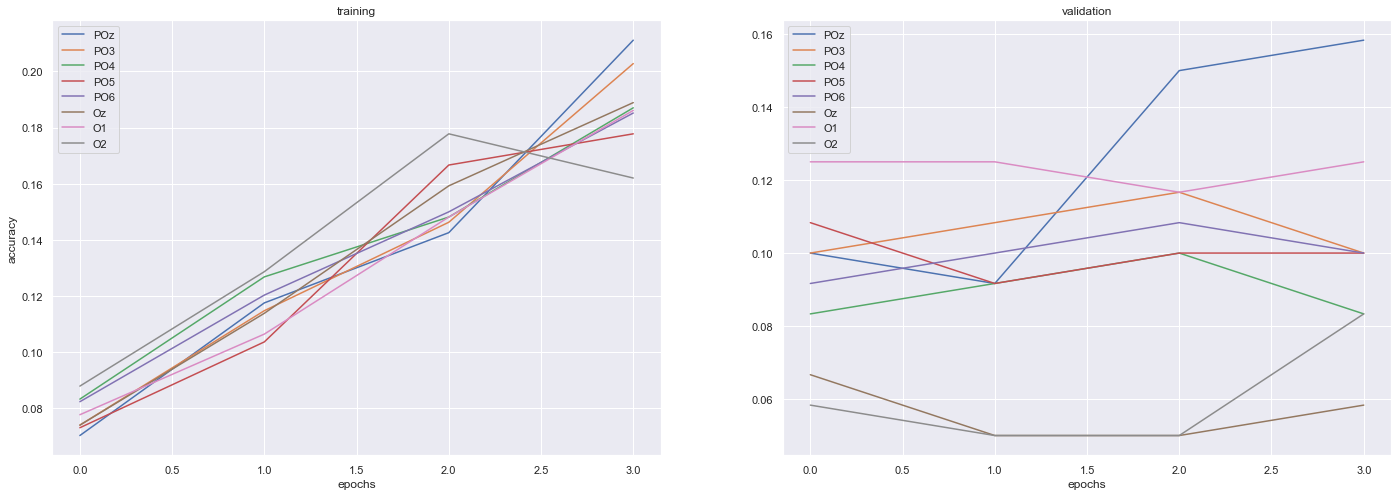

In [24]:
f, (ax_train, ax_val) = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
xticks = list(range(epochs))

for i, chan in enumerate(channels):
    sns.lineplot(x=xticks, y=train_acc[:, i], ax=ax_train)
    sns.lineplot(x=xticks, y=val_acc[:, i], ax=ax_val)
ax_train.legend(channels)
ax_train.set_xlabel('epochs')
ax_train.set_title('training')
ax_train.set_ylabel('accuracy')
ax_val.set_title('validation')
ax_val.set_xlabel('epochs')
ax_val.legend(channels);

Start looking at aggregate of channels

In [25]:
val_acc = np.zeros([epochs, len(channels)])
train_acc = np.zeros(val_acc.shape)

In [ ]:
for i, chan in enumerate(channels):
    print(f"Channel {i + 1}/{len(channels)}")
    train_acc_slice, val_acc_slice = get_eegnet_acc(X_orig, y_orig, channels=channels[0: i + 1], epochs=epochs, verbose=0)
    val_acc[:, i] = val_acc_slice
    train_acc[:, i] = train_acc_slice

Channel 1/8
Channel 2/8
Channel 3/8
Channel 4/8
Channel 5/8
Channel 6/8


In [ ]:
legend = [f"total_chs={i}" for i in range(1, len(channels) + 1)]
f, (ax_train, ax_val) = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
xticks = list(range(epochs))

for i, chan in enumerate(channels):
    sns.lineplot(x=xticks, y=train_acc[:, i], ax=ax_train)
    sns.lineplot(x=xticks, y=val_acc[:, i], ax=ax_val)
ax_train.legend(legend)
ax_train.set_xlabel('epochs')
ax_train.set_title('training')
ax_train.set_ylabel('accuracy')
ax_val.set_title('validation')
ax_val.set_xlabel('epochs')
ax_val.legend(legend);

### Accuracy based on number of blocks (for collecting data)

In [ ]:
val_acc = np.zeros([epochs, meta['num_blocks']])
train_acc = np.zeros([epochs, meta['num_blocks']])

In [ ]:
# it doesn't make sense to use 1 block for cross-validation
for i in range(1, meta['num_blocks']):
    print(f"Block {i + 1}/{meta['num_blocks']}")
    train_acc_slice, val_acc_slice = get_eegnet_acc(X_orig, y_orig, blocks=meta['blocks'][0: i + 1], epochs=epochs, verbose=0)
    val_acc[:, i] = val_acc_slice
    train_acc[:, i] = train_acc_slice

In [ ]:
legend = [f"total_blocks={i}" for i in range(2, meta['num_blocks'] + 1)]
f, (ax_train, ax_val) = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
xticks = list(range(epochs))

for i in range(1, meta['num_blocks']):
    sns.lineplot(x=xticks, y=train_acc[:, i], ax=ax_train)
    sns.lineplot(x=xticks, y=val_acc[:, i], ax=ax_val)
ax_train.legend(legend)
ax_train.set_xlabel('epochs')
ax_train.set_title('training')
ax_train.set_ylabel('accuracy')
ax_val.set_title('validation')
ax_val.set_xlabel('epochs')
ax_val.legend(legend);

### Dynamic stimulus duration 

In [ ]:
interval = 80 # unit: timepoint
min_timepoint = 500 * meta['ms_to_timepoint'] # unit: timepoint
max_timepoint = meta['epoch_length_timepoint'] # unit: timepoint
timepoints = np.arange(min_timepoint, max_timepoint, interval, dtype=np.int)
kf = KFold(n_splits=meta['num_blocks'])

val_acc = np.zeros([epochs, len(timepoints)])
train_acc = np.zeros([epochs, len(timepoints)])
val_acc_single_clf = np.zeros([len(timepoints), kf.n_splits])

# for pad_sequences
maxlen = meta['epoch_length_timepoint']
padding = 'pre'
dtype = 'float32'

#### By training multiple classifiers at different timepoints

In [ ]:
for i in range(0, len(timepoints)):
    print(f"Timepoint chunk: {i + 1}/{len(timepoints)}")
    train_acc_slice, val_acc_slice = get_eegnet_acc(X_orig, y_orig, time=list(range(0, timepoints[i])), epochs=epochs, verbose=0)
    val_acc[:, i] = val_acc_slice
    train_acc[:, i] = train_acc_slice

In [ ]:
legend = [f"timepoints={i}" for i in timepoints]
f, (ax_train, ax_val) = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))
xticks = list(range(epochs))

for i in range(0, len(timepoints)):
    sns.lineplot(x=xticks, y=train_acc[:, i], ax=ax_train)
    sns.lineplot(x=xticks, y=val_acc[:, i], ax=ax_val)
ax_train.legend(legend)
ax_train.set_xlabel('epochs')
ax_train.set_title('training')
ax_train.set_ylabel('accuracy')
ax_val.set_title('validation')
ax_val.set_xlabel('epochs')
ax_val.legend(legend);

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 8))
start = meta['epoch_start'] + timepoints[0] * meta['timepoint_to_ms']
end = meta['epoch_start'] + timepoints[-1] * meta['timepoint_to_ms']
xticks = np.linspace(start, end, len(timepoints))

# use the last epoch as the prediction accuracy
sns.lineplot(x=xticks, y=train_acc[-1, :], ax=ax, label='training')
sns.lineplot(x=xticks, y=val_acc[-1, :], ax=ax, label='testing')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('accuracy');

#### By training single classifier using the entire epoch

In [ ]:
# populate inputs
X = np.zeros([meta['num_blocks'], len(timepoints)] + list(X_orig.shape[1:]))
y = np.zeros([meta['num_blocks'], len(timepoints), meta['num_classes']])
for i, timepoint in enumerate(timepoints):
    for j in range(X.shape[0]):
        padded = pad_sequences(X_orig[j, :, :, 0:timepoint].transpose([0, 2, 1, 3]), maxlen=maxlen, padding=padding, dtype=dtype)
        padded = padded.transpose([0, 2, 1, 3])
        X[j, i] = padded
        y[j, i] = y_orig[j]

In [ ]:
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"{i + 1} / {meta['num_blocks']} folds")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train = X_train.reshape([-1, X_train.shape[-3], X_train.shape[-2], X_train.shape[-1]])
    y_train = y_train.reshape([-1])

    model = EEGNet(nb_classes = meta['num_classes'], Chans = len(channels), 
              Samples = meta['epoch_length_timepoint'])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=lr), 
              metrics = ['acc'])

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
  
    for j in range(len(timepoints)):
        X_test_slice = np.squeeze(X_test[:, j], axis=0)
        y_test_slice = y_test[:, j, :].reshape([-1])
        y_hat = model.predict(X_test_slice)
        y_hat = np.argmax(y_hat, axis=1)
        val_acc_single_clf[j, i] = accuracy_score(y_test_slice, y_hat)
   

In [ ]:
val_acc_single_clf_avg = val_acc_single_clf.mean(axis=-1)
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 8))
start = meta['epoch_start'] + timepoints[0] * meta['timepoint_to_ms']
end = meta['epoch_start'] + timepoints[-1] * meta['timepoint_to_ms']
xticks = np.linspace(start, end, len(timepoints))

# use the last epoch as the prediction accuracy
sns.lineplot(x=xticks, y=val_acc_single_clf_avg, ax=ax, label='single clf')
sns.lineplot(x=xticks, y=val_acc[-1, :], ax=ax, label='multiple clf')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('accuracy');

# plot ITR with confidence interval for each subject

In [ ]:
import math 

def getsd(acc):
    return 1.96 *math.sqrt((acc*(1-acc))/interval)

def getITR(acc):
    return math.log(meta['num_classes'],2)+(acc)*(math.log(acc,2))+(1-acc)*(math.log((1-acc)/(meta['num_classes']-1),2))/int(epoch_length)

def graphITRwithCI(val_acc):
    sdvec=np.vectorize(getsd)
    ITRvec=np.vectorize(getITR)
    sd=sdvec(val_acc[-1,:]) #(8,)
    ITR=ITRvec(val_acc[-1,:])
    
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 8))
    sns.lineplot(x=xticks, y=ITR, ax=ax, label=f"ITR Subject_idx: {subject_idx+1}/{len(patient_data)}")
    ax.fill_between(xticks,(ITR-sd),(ITR+sd),color='b', alpha=.1)
    
    plt.show()

val_acc = np.zeros([epochs, len(timepoints)])
train_acc = np.zeros([epochs, len(timepoints)])

val_acc_all_subjects=np.zeros([len(patient_data),len(timepoints)])

for subject_idx in range (0,len(patient_data)):
    print(f"Subject_idx: {subject_idx + 1}/{len(patient_data)}")
    X_orig = X_all_subjects[subject_idx]
    y_orig = y_all_subjects[subject_idx]
    # reshape to required dimension
    X_orig = X_orig[:, :, :, :, None]
    
    #train multiple classifiers at different timepoints
    for i in range(0, len(timepoints)):
        print(f"Timepoint chunk: {i + 1}/{len(timepoints)}")
        train_acc_slice, val_acc_slice = get_eegnet_acc(X_orig, y_orig, time=list(range(0, timepoints[i])), epochs=epochs, verbose=0)
        val_acc[:, i] = val_acc_slice
        train_acc[:, i] = train_acc_slice
   
    val_acc_all_subjects[subject_idx]=val_acc[-1,:]   
    graphITRwithCI(val_acc)


In [ ]:
#agrregate ITR of all subjects

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 8))
start = meta['epoch_start'] + timepoints[0] * meta['timepoint_to_ms']
end = meta['epoch_start'] + timepoints[-1] * meta['timepoint_to_ms']
xticks = np.linspace(start, end, len(timepoints))

ax.set_xlabel('Time (ms)')
ax.set_ylabel('ITR');

for i in range(0, len(patient_data)):
    Subject_idx=i
    graphITRwithCI(val_acc_all_subjects[i])